# Seq2Seq
By Pranav Goyal

In [1]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from nltk.translate.bleu_score import sentence_bleu

### GPU Configuration

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

### Data Preprocessing

In [4]:
df = pd.read_pickle('en_hi_data/en_hi.pkl')

In [5]:
df

,english,hindi
57382,Who is this man?\n,-ये आदमी कौन है ?\n
28149,And the other brother?\n,और दूसरे भाई?\n
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n"
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n"
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n
...,...,...
80140,"""Let's enjoy this life, sweetheart.""\n","""हम इस जीवन, जानेमन का आनंद लें।""\n"
66651,Let's get out of here.\n,चलो अब चलो यहाँ से .\n
35946,WE'RE GOING TO THE GARAGE.\n,हम गेराज के लिए जा रहे हैं.\n
44917,It's gonna be dark soon.\n,यह जल्द ही अंधेरा होने वाला है.\n


In [6]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    
    text = text.lower()
    
    text = re.sub(r"\\n", "", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"'s", " 's", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    # removing the punctuations
    text = re.sub(r'([-()\"#/@;:<>{}`।+=~|.!?\",])', r"", text)
    text = re.sub(r" [ ]*", " ", text)
    text = text.strip()
    
    text = text.split(' ')
    return text

In [7]:
df['cleaned_english'] = df['english'].apply(clean_text)
df['english_len'] = df['cleaned_english'].apply(lambda x: len(x))
df['cleaned_hindi'] = df['hindi'].apply(clean_text)
df['hindi_len'] = df['cleaned_hindi'].apply(lambda x: len(x))
df['cleaned_hindi'] = df['cleaned_hindi'].apply(lambda x: ['<begin>']+x+['<end>'])

In [8]:
df

,english,hindi,cleaned_english,english_len,cleaned_hindi,hindi_len
57382,Who is this man?\n,-ये आदमी कौन है ?\n,"[who, is, this, man]",4,"[<begin>, ये, आदमी, कौन, है, <end>]",4
28149,And the other brother?\n,और दूसरे भाई?\n,"[and, the, other, brother]",4,"[<begin>, और, दूसरे, भाई, <end>]",3
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n","[greetings, mustakeen, bhai]",3,"[<begin>, नमस्ते, mustakeen, भाई, <end>]",3
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n","[please, reason, with, them]",4,"[<begin>, कृपया, उन, लोगों, के, साथ, कारण, <end>]",6
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n,"[there, is, a, howling, gale]",5,"[<begin>, तेज़, हवा, आ, रही, है, <end>]",5
...,...,...,...,...,...,...
80140,"""Let's enjoy this life, sweetheart.""\n","""हम इस जीवन, जानेमन का आनंद लें।""\n","[let, us, enjoy, this, life, sweetheart]",6,"[<begin>, हम, इस, जीवन, जानेमन, का, आनंद, लें,...",7
66651,Let's get out of here.\n,चलो अब चलो यहाँ से .\n,"[let, us, get, out, of, here]",6,"[<begin>, चलो, अब, चलो, यहाँ, से, <end>]",5
35946,WE'RE GOING TO THE GARAGE.\n,हम गेराज के लिए जा रहे हैं.\n,"[we, are, going, to, the, garage]",6,"[<begin>, हम, गेराज, के, लिए, जा, रहे, हैं, <e...",7
44917,It's gonna be dark soon.\n,यह जल्द ही अंधेरा होने वाला है.\n,"[it, is, gonna, be, dark, soon]",6,"[<begin>, यह, जल्द, ही, अंधेरा, होने, वाला, है...",7


In [9]:
df.describe()

,english_len,hindi_len
count,10000.000000,10000.000000
mean,4.657800,5.117600
std,0.819491,1.782607
min,1.000000,1.000000
25%,4.000000,4.000000
50%,5.000000,5.000000
75%,5.000000,6.000000
max,8.000000,28.000000


In [10]:
english_max_len = 8
hindi_max_len = 30

In [11]:
# examples of bad translations
df[(df['hindi_len']-df['english_len'])>5]

,english,hindi,cleaned_english,english_len,cleaned_hindi,hindi_len
68992,Start anywhere you like.\n,विनाश का दिवस जहाँ से चाहो शुरू कर सकते हो।\n,"[start, anywhere, you, like]",4,"[<begin>, विनाश, का, दिवस, जहाँ, से, चाहो, शुर...",10
32941,A little unfinished business.\n,वह बेबी जैक पाया और वह उसे सुरक्षित रखने के लि...,"[a, little, unfinished, business]",4,"[<begin>, वह, बेबी, जैक, पाया, और, वह, उसे, सु...",28
91719,I can't remember. Really?\n,"और तकनीकी तौर पर तुम एक मूर्ख हो, नहीं हो क्या?\n","[i, cannot, remember, really]",4,"[<begin>, और, तकनीकी, तौर, पर, तुम, एक, मूर्ख,...",11
66849,Hard to know. Years?\n,"कहना जरा कठिन है, फिर भी कुछ साल तो जरुर लगेंग...","[hard, to, know, years]",4,"[<begin>, कहना, जरा, कठिन, है, फिर, भी, कुछ, स...",11
19117,Track ahead looks good.\n,मैं ऐसा नहीं करोगे. लगता है एल एल कुछ देखना.\n,"[track, ahead, looks, good]",4,"[<begin>, मैं, ऐसा, नहीं, करोगे, लगता, है, एल,...",10
...,...,...,...,...,...,...
2529,KDK 1 calling KDK 12.\n,के डी के 1बुला रहा है के डी के 12 को.\n,"[kdk, 1, calling, kdk, 12]",5,"[<begin>, के, डी, के, 1बुला, रहा, है, के, डी, ...",11
90490,"Well, that's very flattering, Andy.\n",तो यह इंटरव्यू ख़त्म हुआ समझो। यह बहुत ख़ुशी देन...,"[well, that, is, very, flattering, andy]",6,"[<begin>, तो, यह, इंटरव्यू, ख़त्म, हुआ, समझो, य...",13
78153,I can't feel my legs.\n,मैं अपने पैरों को महसूस नहीं कर सकते हैं कर सक...,"[i, cannot, feel, my, legs]",5,"[<begin>, मैं, अपने, पैरों, को, महसूस, नहीं, क...",12
2538,KDK 1 calling KDK 12.\n,के डी के 1 बुला रहा है के डी के 12 को.\n,"[kdk, 1, calling, kdk, 12]",5,"[<begin>, के, डी, के, 1, बुला, रहा, है, के, डी...",12


In [12]:
def make_vocab(all_sentences):
    vocab = defaultdict(int)
    for sent in all_sentences:
        for word in sent:
            vocab[word] += 1
    return vocab

english_vocab = make_vocab(df['cleaned_english'])
hindi_vocab = make_vocab(df['cleaned_hindi'])

In [13]:
len(english_vocab)

5499

In [14]:
len(hindi_vocab)

6539

In [15]:
sum(value > 1 for value in english_vocab.values())

2357

In [16]:
sum(value > 1 for value in hindi_vocab.values())

2701

was planning to convert non-frequent words to UNK but the dataset has too many of those and therefore would result in unnecessary high bleu score.

In [17]:
# Loading Glove model ebeddings for input to encoder
f = open('glove.6B.300d.txt','r')
gloveModel = {}
for line in tqdm(f):
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.array([float(value) for value in splitLines[1:]])
    gloveModel[word] = wordEmbedding
print(len(gloveModel)," words loaded!")

400000it [00:31, 12699.85it/s]

400000  words loaded!


In [18]:
embedding_dim = 300

In [19]:
hits = 0
misses = 0
for word in english_vocab.keys():
    if word in gloveModel:
        hits+=1
    else:
        misses+=1
print(hits,misses)

5172 327


so most of the words do have the embeddings

In [20]:
# Loading Glove model ebeddings for input to encoder
f = open('hi/hi_new.tsv','r')
hindi_embeddings = {}
for line in tqdm(f):
    try:
        splitLines = line.split('\t')
        word = splitLines[1]
        emb = re.sub('\n','',splitLines[2].strip())
        emb = re.sub(r' [ ]*',' ',emb)
        emb= emb.split(' ')
        wordEmbedding = np.array([float(value) for value in emb])
        hindi_embeddings[word] = wordEmbedding
    except Exception as e:
        pass
print(len(hindi_embeddings)," words loaded!")

30394it [00:04, 6579.29it/s]

30393  words loaded!


In [21]:
hits = 0
misses = 0
for word in hindi_vocab.keys():
    if word in hindi_embeddings:
        hits+=1
    else:
        misses+=1
print(hits,misses)

4246 2293


Large amount of misses, so sticking to one-hot encoding

In [22]:
'unk' in gloveModel

True

In [23]:
index2word = ['<padding>'] + list(english_vocab.keys())
word2index = {}
for i,word in enumerate(index2word):
    word2index[word]=i

In [24]:
hi_index2word = ['<padding>'] + list(hindi_vocab.keys())
hi_word2index = {}
for i,word in enumerate(hi_index2word):
    hi_word2index[word]=i

In [25]:
def convert_eng(sentence, max_size=english_max_len):
    result = [0]*max_size
    for i,word in enumerate(sentence):
        result[i] = word2index[word]
    result.reverse()
    return result

In [26]:
def convert_hin(sentence, max_size=hindi_max_len):
    result = [0]*max_size
    for i,word in enumerate(sentence):
        result[i] = hi_word2index[word]
    return result

In [27]:
df['encoder_input'] = df['cleaned_english'].apply(convert_eng)
df['decoder_input'] = df['cleaned_hindi'].apply(convert_hin)
df['decoder_output'] = df['decoder_input'].apply(lambda x: x[1:]+[0])
df

,english,hindi,cleaned_english,english_len,cleaned_hindi,hindi_len,encoder_input,decoder_input,decoder_output
57382,Who is this man?\n,-ये आदमी कौन है ?\n,"[who, is, this, man]",4,"[<begin>, ये, आदमी, कौन, है, <end>]",4,"[0, 0, 0, 0, 4, 3, 2, 1]","[1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28149,And the other brother?\n,और दूसरे भाई?\n,"[and, the, other, brother]",4,"[<begin>, और, दूसरे, भाई, <end>]",3,"[0, 0, 0, 0, 8, 7, 6, 5]","[1, 7, 8, 9, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7, 8, 9, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n","[greetings, mustakeen, bhai]",3,"[<begin>, नमस्ते, mustakeen, भाई, <end>]",3,"[0, 0, 0, 0, 0, 11, 10, 9]","[1, 10, 11, 9, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[10, 11, 9, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n","[please, reason, with, them]",4,"[<begin>, कृपया, उन, लोगों, के, साथ, कारण, <end>]",6,"[0, 0, 0, 0, 15, 14, 13, 12]","[1, 12, 13, 14, 15, 16, 17, 6, 0, 0, 0, 0, 0, ...","[12, 13, 14, 15, 16, 17, 6, 0, 0, 0, 0, 0, 0, ..."
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n,"[there, is, a, howling, gale]",5,"[<begin>, तेज़, हवा, आ, रही, है, <end>]",5,"[0, 0, 0, 19, 18, 17, 2, 16]","[1, 18, 19, 20, 21, 5, 6, 0, 0, 0, 0, 0, 0, 0,...","[18, 19, 20, 21, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...
80140,"""Let's enjoy this life, sweetheart.""\n","""हम इस जीवन, जानेमन का आनंद लें।""\n","[let, us, enjoy, this, life, sweetheart]",6,"[<begin>, हम, इस, जीवन, जानेमन, का, आनंद, लें,...",7,"[0, 0, 2198, 360, 3, 2152, 51, 50]","[1, 161, 109, 411, 2574, 62, 2522, 2804, 6, 0,...","[161, 109, 411, 2574, 62, 2522, 2804, 6, 0, 0,..."
66651,Let's get out of here.\n,चलो अब चलो यहाँ से .\n,"[let, us, get, out, of, here]",6,"[<begin>, चलो, अब, चलो, यहाँ, से, <end>]",5,"[0, 0, 66, 54, 234, 167, 51, 50]","[1, 58, 40, 58, 74, 71, 6, 0, 0, 0, 0, 0, 0, 0...","[58, 40, 58, 74, 71, 6, 0, 0, 0, 0, 0, 0, 0, 0..."
35946,WE'RE GOING TO THE GARAGE.\n,हम गेराज के लिए जा रहे हैं.\n,"[we, are, going, to, the, garage]",6,"[<begin>, हम, गेराज, के, लिए, जा, रहे, हैं, <e...",7,"[0, 0, 128, 6, 149, 572, 95, 134]","[1, 161, 6539, 15, 122, 434, 190, 54, 6, 0, 0,...","[161, 6539, 15, 122, 434, 190, 54, 6, 0, 0, 0,..."
44917,It's gonna be dark soon.\n,यह जल्द ही अंधेरा होने वाला है.\n,"[it, is, gonna, be, dark, soon]",6,"[<begin>, यह, जल्द, ही, अंधेरा, होने, वाला, है...",7,"[0, 0, 1567, 2306, 251, 366, 2, 43]","[1, 41, 2578, 119, 3210, 418, 155, 5, 6, 0, 0,...","[41, 2578, 119, 3210, 418, 155, 5, 6, 0, 0, 0,..."


In [28]:
def hi_sentences_to_onehot(decoder_input_data, max_len=hindi_max_len, vocab_size=len(hi_index2word)):
    num_samples = decoder_input_data.shape[0]
    decoder_output_data = np.zeros((num_samples, max_len, vocab_size), dtype="float32")

    for i, sents in enumerate(decoder_input_data):
        for j, word in enumerate(sents):
            decoder_output_data[i][j][word] = 1.
    return decoder_output_data

In [29]:
def get_inputs(temp):
    encoder_input = np.stack(temp['encoder_input'].to_numpy(),axis=1).T
    decoder_input = hi_sentences_to_onehot(np.stack(temp['decoder_input'].to_numpy(),axis=1).T)
    decoder_output = hi_sentences_to_onehot(np.stack(temp['decoder_output'].to_numpy(),axis=1).T)
    return encoder_input,decoder_input,decoder_output

In [30]:
train, validate, test = np.split(df.sample(frac=1,random_state=0), [int(.7*len(df)), int(.8*len(df))])

In [31]:
train_x1,train_x2,train_y = get_inputs(train)
val_x1,val_x2,val_y = get_inputs(validate)

In [32]:
embedding_matrix = np.zeros((len(index2word), embedding_dim))
for word, i in word2index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    elif i!=0:
        embedding_matrix[i] = gloveModel.get('unk')

## Build Model

In [33]:
eng_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedding_layer = layers.Embedding(
    len(index2word),
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)
embedded_sequences = embedding_layer(eng_sequences_input)

In [34]:
lstm_dim = 100
lstm1 = layers.LSTM(lstm_dim,return_sequences=True)(embedded_sequences)
encoder_lstm_layer = layers.LSTM(lstm_dim, return_state=True)
encoder_lstm,state_h,state_c = encoder_lstm_layer(lstm1)

In [35]:
hi_sequences_input = keras.Input(shape=(None,len(hi_index2word)), dtype="float32")
decoder_lstm = layers.LSTM(lstm_dim, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(hi_sequences_input, initial_state=[state_h, state_c])
prediction_layer = layers.Dense(len(hi_index2word), activation='softmax')
hi_sequences_output = prediction_layer(decoder_outputs)

In [36]:
model = keras.Model([eng_sequences_input, hi_sequences_input], hi_sequences_output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    1650000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 100)    160400      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 6540)] 0                                            
_______________________________________________________________________________________

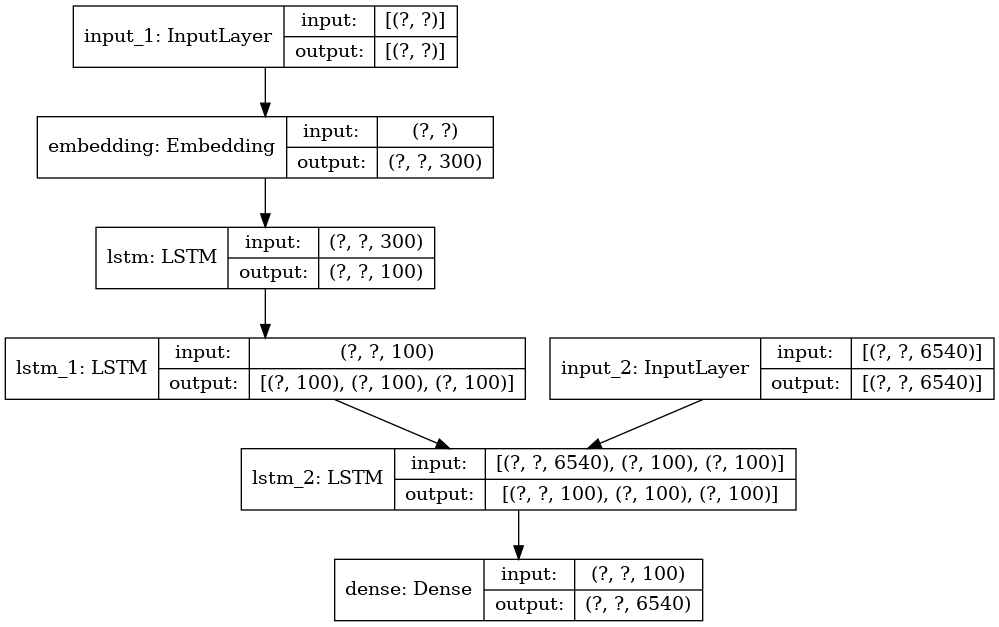

In [37]:
keras.utils.plot_model(model, "seq2seq.png", show_shapes=True)

In [38]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
hist = model.fit([train_x1, train_x2], train_y, batch_size=20, epochs=10,
                            validation_data=([val_x1, val_x2], val_y))

Epoch 1/10
350/350 [==============================] - 15s 44ms/step - loss: 1.5493 - accuracy: 0.8060 - val_loss: 1.1469 - val_accuracy: 0.8317
Epoch 2/10
350/350 [==============================] - 12s 35ms/step - loss: 1.0965 - accuracy: 0.8356 - val_loss: 1.0652 - val_accuracy: 0.8408
Epoch 3/10
350/350 [==============================] - 12s 36ms/step - loss: 1.0240 - accuracy: 0.8451 - val_loss: 1.0186 - val_accuracy: 0.8513
Epoch 4/10
350/350 [==============================] - 13s 37ms/step - loss: 0.9732 - accuracy: 0.8537 - val_loss: 0.9848 - val_accuracy: 0.8555
Epoch 5/10
350/350 [==============================] - 13s 38ms/step - loss: 0.9333 - accuracy: 0.8591 - val_loss: 0.9567 - val_accuracy: 0.8606
Epoch 6/10
350/350 [==============================] - 13s 36ms/step - loss: 0.8990 - accuracy: 0.8637 - val_loss: 0.9366 - val_accuracy: 0.8639
Epoch 7/10
350/350 [==============================] - 12s 35ms/step - loss: 0.8696 - accuracy: 0.8678 - val_loss: 0.9228 - val_accuracy:

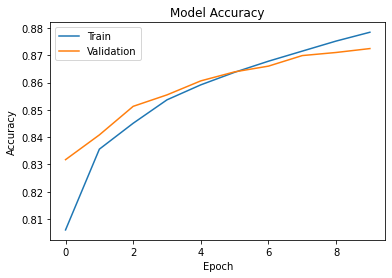

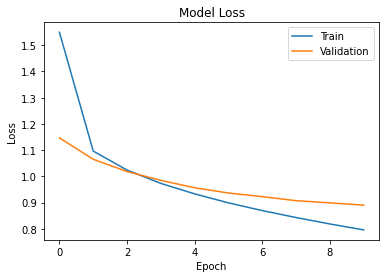

In [40]:
# Plot accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [41]:
model.save("results/seq2seq",save_format= "h5")

### Inference

In [42]:
encoder_model = keras.Model(eng_sequences_input,[state_h, state_c])
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         1650000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         160400    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 100), (None, 100) 80400     
Total params: 1,890,800
Trainable params: 240,800
Non-trainable params: 1,650,000
_________________________________________________________________


In [43]:
decoder_state_input_h = layers.Input(shape=(lstm_dim,))
decoder_state_input_c = layers.Input(shape=(lstm_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(hi_sequences_input, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = prediction_layer(decoder_outputs)
decoder_model = keras.Model(
    [hi_sequences_input] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 6540)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 100),  2656400     input_2[0][0]                    
                                                                 input_3[0][0]         

In [44]:
def to_one_hot(predicted_word):
    hi_sent_input = np.zeros((1,1,len(hi_index2word)))
    hi_sent_input[0][0][hi_word2index[predicted_word]]=1
    return hi_sent_input
    
def translate_sentence(eng_sent):
    eng_sent=np.array([eng_sent])
    state1,state2 = encoder_model.predict(eng_sent)
    predicted_word = '<begin>'
    hi_sent_input = to_one_hot(predicted_word)
    generated_translation = [predicted_word]
    while predicted_word != '<end>' and len(generated_translation)<hindi_max_len:
        new_word,state1,state2 = decoder_model.predict([hi_sent_input,state1,state2])
        predicted_word = np.argmax(new_word[0, -1, :])
        predicted_word = hi_index2word[predicted_word]
        generated_translation.append(predicted_word)
        hi_sent_input = to_one_hot(predicted_word)
    return generated_translation

In [45]:
print(translate_sentence([0,0,0,0,0,4,3,2,1]))

['<begin>', 'वह', 'यह', 'है', '<end>']


In [46]:
tqdm.pandas()
test['generated_translation'] = test['encoder_input'].progress_apply(lambda x: translate_sentence(x))

/home/pranav/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 2000/2000 [07:52<00:00,  4.23it/s]


In [47]:
def get_score_bleu(x):
    sent1 = ' '.join(x['cleaned_hindi'][1:-1])
    sent2 = ' '.join(x['generated_translation'][1:-1])
    return sentence_bleu([sent1],sent2)
test['bleu_score'] = test.progress_apply(get_score_bleu,axis=1)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/pranav/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/pranav/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/pranav/.local/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using

In [48]:
test[test['bleu_score']>0.9]

,english,hindi,cleaned_english,english_len,cleaned_hindi,hindi_len,encoder_input,decoder_input,decoder_output,generated_translation,bleu_score
56225,"- Oh, my God.\n","- ओह, मेरे भगवान.\n","[oh, my, god]",3,"[<begin>, ओह, मेरे, भगवान, <end>]",3,"[0, 0, 0, 0, 0, 185, 76, 184]","[1, 216, 99, 217, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[216, 99, 217, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[<begin>, ओह, मेरे, भगवान, <end>]",1.0
78317,"No, no, no... ma'am.\n","नहीं, नहीं, नहीं ...\n","[no, no, no, ma'am]",4,"[<begin>, नहीं, नहीं, नहीं, <end>]",3,"[0, 0, 0, 0, 106, 20, 20, 20]","[1, 22, 22, 22, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[22, 22, 22, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[<begin>, नहीं, नहीं, नहीं, <end>]",1.0
30614,man speaking native language:\n,पुरुष अपनी मातृभाषा में बोल रहा है:\n,"[man, speaking, native, language]",4,"[<begin>, पुरुष, अपनी, मातृभाषा, में, बोल, रहा...",7,"[0, 0, 0, 0, 748, 747, 746, 4]","[1, 1072, 82, 849, 28, 555, 46, 5, 6, 0, 0, 0,...","[1072, 82, 849, 28, 555, 46, 5, 6, 0, 0, 0, 0,...","[<begin>, पुरुष, अपनी, मातृभाषा, में, बोल, रहा...",1.0
30715,man speaking native language:\n,पुरुष अपनी मातृभाषा में बोल रहा है:\n,"[man, speaking, native, language]",4,"[<begin>, पुरुष, अपनी, मातृभाषा, में, बोल, रहा...",7,"[0, 0, 0, 0, 748, 747, 746, 4]","[1, 1072, 82, 849, 28, 555, 46, 5, 6, 0, 0, 0,...","[1072, 82, 849, 28, 555, 46, 5, 6, 0, 0, 0, 0,...","[<begin>, पुरुष, अपनी, मातृभाषा, में, बोल, रहा...",1.0
46357,We gotta get out.\n,हम बाहर जाना होगा.\n,"[we, gotta, get, out]",4,"[<begin>, हम, बाहर, जाना, होगा, <end>]",4,"[0, 0, 0, 0, 234, 167, 704, 134]","[1, 161, 185, 804, 203, 6, 0, 0, 0, 0, 0, 0, 0...","[161, 185, 804, 203, 6, 0, 0, 0, 0, 0, 0, 0, 0...","[<begin>, हम, बाहर, जाना, होगा, <end>]",1.0
75487,- What are you doing?\n,- तुम क्या कर रहे हो?\n,"[what, are, you, doing]",4,"[<begin>, तुम, क्या, कर, रहे, हो, <end>]",5,"[0, 0, 0, 0, 37, 21, 95, 90]","[1, 30, 176, 45, 190, 36, 6, 0, 0, 0, 0, 0, 0,...","[30, 176, 45, 190, 36, 6, 0, 0, 0, 0, 0, 0, 0,...","[<begin>, तुम, क्या, कर, रहे, हो, <end>]",1.0
11420,Are you all right?\n,तुम ठीक हो?\n,"[are, you, all, right]",4,"[<begin>, तुम, ठीक, हो, <end>]",3,"[0, 0, 0, 0, 274, 309, 21, 95]","[1, 30, 98, 36, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[30, 98, 36, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[<begin>, तुम, ठीक, हो, <end>]",1.0
372,"- No, I don't.\n","- नहीं, मैं नहीं.\n","[no, i, do, not]",4,"[<begin>, नहीं, मैं, नहीं, <end>]",3,"[0, 0, 0, 0, 23, 22, 73, 20]","[1, 22, 81, 22, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[22, 81, 22, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[<begin>, नहीं, मैं, नहीं, <end>]",1.0
87924,- What are you doing?\n,- तुम क्या कर रहे हो?\n,"[what, are, you, doing]",4,"[<begin>, तुम, क्या, कर, रहे, हो, <end>]",5,"[0, 0, 0, 0, 37, 21, 95, 90]","[1, 30, 176, 45, 190, 36, 6, 0, 0, 0, 0, 0, 0,...","[30, 176, 45, 190, 36, 6, 0, 0, 0, 0, 0, 0, 0,...","[<begin>, तुम, क्या, कर, रहे, हो, <end>]",1.0
30644,man speaking native language:\n,पुरुष अपनी मातृभाषा में बोल रहा है:\n,"[man, speaking, native, language]",4,"[<begin>, पुरुष, अपनी, मातृभाषा, में, बोल, रहा...",7,"[0, 0, 0, 0, 748, 747, 746, 4]","[1, 1072, 82, 849, 28, 555, 46, 5, 6, 0, 0, 0,...","[1072, 82, 849, 28, 555, 46, 5, 6, 0, 0, 0, 0,...","[<begin>, पुरुष, अपनी, मातृभाषा, में, बोल, रहा...",1.0


In [49]:
test.describe()

,english_len,hindi_len,bleu_score
count,2000.000000,2000.000000,2.000000e+03
mean,4.652500,5.072000,2.033225e-01
std,0.860299,1.877652,2.004191e-01
min,1.000000,1.000000,0.000000e+00
25%,4.000000,4.000000,2.405452e-78
50%,5.000000,5.000000,1.787681e-01
75%,5.000000,6.000000,3.311098e-01
max,8.000000,28.000000,1.000000e+00


In [50]:
test.to_pickle('results/test_seq2seq.pickle')